## **Behind the pipeline**

This pipeline groups together three steps: preprocessing, passing the inputs through the model, and postprocessing:

In [3]:
import warnings
warnings.filterwarnings('ignore')

from transformers import pipeline

sentiment = pipeline('sentiment-analysis')

sentiment([
    'Hi, I am happy becuase i am feeling sad.',
    'Hi, I am sad becuase i am happy.'
    ])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9909998774528503},
 {'label': 'POSITIVE', 'score': 0.9997718930244446}]

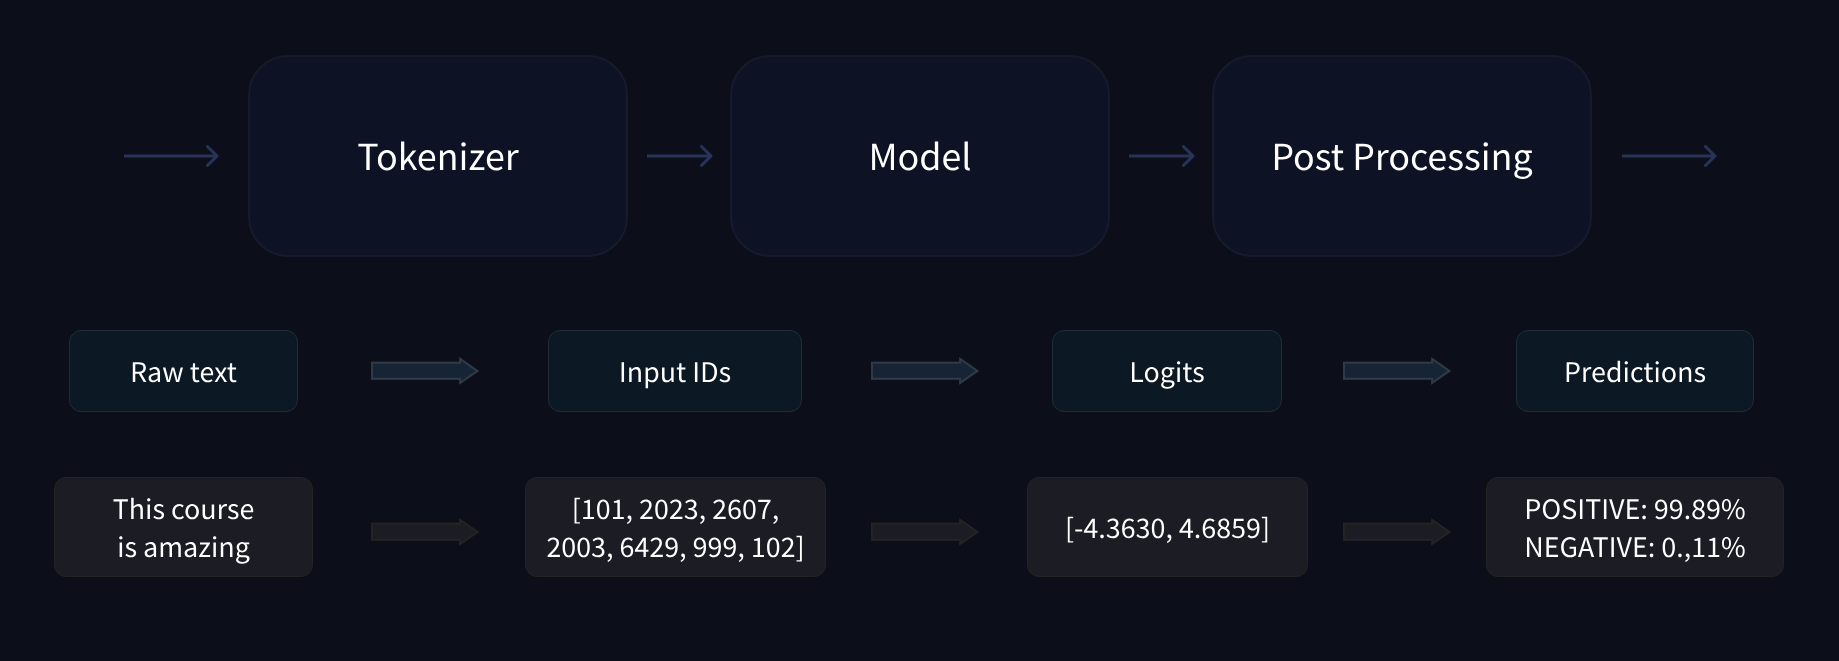

### **1. Preprocessing with a tokenizer**

Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a **tokenizer**.

1. Splitting the input into words, subwords, or symbols (like punctuation) that are called **tokens**
2. Mapping each token to an integer
3. Adding additional inputs that may be useful to the model

All this **preprocessing** needs to be done in exactly **the same way as when the model was pretrained**, so we first need to download that information from the [Model Hub](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).

we use the **AutoTokenizer** class and its **from_pretrained**() method.
Using the **checkpoint** name of our model, it will automatically fetch the data associated with the **model’s tokenizer** and cache it (so it’s only downloaded the first time you run the code below).

Checkpoint - Here we are using word checkpoint because checkpoint is saved state of the model's weights, architecture, and optimizer state at a specific training step.

What ever the initial condition of our model, we are taking as checkpoint.

Since the default checkpoint of the sentiment-analysis pipeline is **distilbert-base-uncased-finetuned-sst-2-english**

In [4]:
from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased-finetuned-sst-2-english'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)


Once we have the tokenizer, we can directly pass our sentences to it and we’ll get back a dictionary that’s ready to feed to our model! **The only thing left to do is to convert the list of input IDs to tensors**.

You can use 🤗 Transformers without having to worry about which ML framework is used as a backend; it might be PyTorch or TensorFlow, or Flax for some models. However, Transformer models only **accept tensors** as input.

**What is Tensor?**

A tensor is a multi-dimensional array, similar to a NumPy array, but optimized for deep learning. It is the core data structure used in ML frameworks like PyTorch, TensorFlow, and JAX.

Think of tensors as:
```
✅ Scalars (0D) → Single numbers (e.g., 5).
✅ Vectors (1D) → A list of numbers (e.g., [1, 2, 3]).
✅ Matrices (2D) → A grid of numbers (e.g., [[1, 2], [3, 4]]).
✅ Higher Dimensions (3D, 4D, etc.) → Used for complex data like images
or NLP inputs.
```

```python
# Example in Pytorch
import torch

# Creating a tensor
tensor = torch.tensor([[1, 2], [3, 4]])
print(tensor)
```
Output:
```
tensor([[1, 2],
        [3, 4]])
```

**How Transformers Use Tensors?**

Since models only accept tensors, when you tokenize text using Hugging Face Transformers, the output is converted into tensor format automatically.

In [5]:
# Example in Pytorch
import torch

# Creating a tensor
tensor = torch.tensor([[1, 2], [3, 4]])
print(tensor)

tensor([[1, 2],
        [3, 4]])


In [6]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="tf") # Here tf means tensorflow tensor
print(inputs)

{'input_ids': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662,
        12172,  2607,  2026,  2878,  2166,  1012,   102],
       [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,
            0,     0,     0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}


The output itself is a dictionary containing two keys, **input_ids** and **attention_mask**. input_ids contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence.

### **2. Going through the model**

We can download our pretrained model the same way we did with our tokenizer. 🤗 Transformers provides an TFAutoModel class which also has a from_pretrained method.

In [7]:
from transformers import TFAutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModel.from_pretrained(checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**What Does TFAutoModel.from_pretrained(checkpoint) Do?**

1. Downloads the model checkpoint (DistilBERT fine-tuned on SST-2).
3. Loads only the base Transformer model (without a task-specific head).
3. Outputs hidden states (features) instead of final predictions.

Since task specific head is not available. So it will return hiddent states or we can say features.

**While these hidden states can be useful on their own, they’re usually inputs to another part of the model, known as the head.**

**A high-dimensional vector?**

The vector output by the Transformer module is usually large. It generally has three dimensions:

1. Batch size: The number of sequences processed at a time (2 in our example).
2. Sequence length: The length of the numerical representation of the sequence (16 in our example).
3. Hidden size: The vector dimension of each model input.


It is said to be “high dimensional” because of the last value. The hidden size can be very large (768 is common for smaller models, and in larger models this can reach 3072 or more).

In [8]:
# Passing our input token to model

outputs = model(inputs)
print(outputs.last_hidden_state.shape)

(2, 16, 768)


```
Batch Size - 2
Sequence Lenght - 16
Hidden size - 768
```

Note that the outputs of 🤗 Transformers models behave like namedtuples or dictionaries. You can access the elements by attributes (like we did) or by key (**outputs["last_hidden_state"]**), or even by **index** if you know exactly where the thing you are looking for is (**outputs[0]**).

### **3. Model heads: Making sense out of numbers**

The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers.

The output of the Transformer model is sent directly to the model head to be processed.

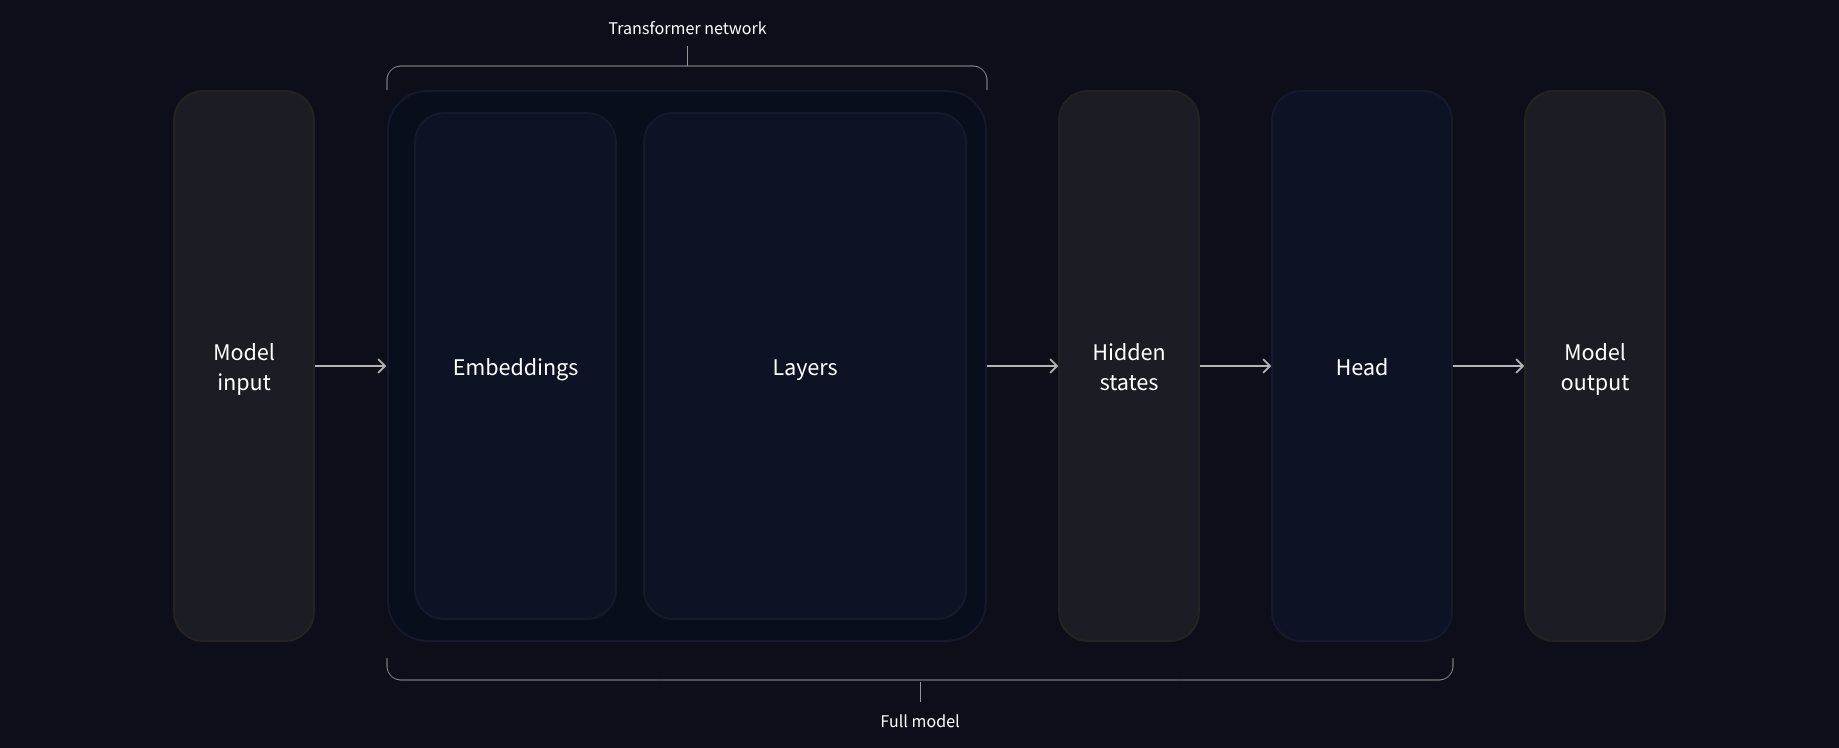

In this diagram, the model is represented by its **embeddings layer** and the **subsequent layers**. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the **attention mechanism** to produce the final representation of the sentences.

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task.

* Model (retrieve the hidden states)
* ForCausalLM
* ForMaskedLM
* ForMultipleChoice
* ForQuestionAnswering
* ForSequenceClassification
* ForTokenClassification
* etc.

For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the TFAutoModel class, but **TFAutoModelForSequenceClassification**.

In [9]:
from transformers import TFAutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(inputs)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [10]:
print(outputs.logits.shape)

(2, 2)


Now if we look at the shape of our outputs, the dimensionality will be much lower: the model head takes as input the high-dimensional vectors we saw before, and outputs vectors containing two values (one per label):

**Since we have just two sentences and two labels, the result we get from our model is of shape 2 x 2.**

### **4. Postprocessing the output**

The values we get as output from our model don’t necessarily make sense by themselves. Let’s take a look:

In [11]:
print(outputs.logits)

tf.Tensor(
[[-1.5606961  1.6122813]
 [ 4.1692314 -3.3464477]], shape=(2, 2), dtype=float32)


Our model predicted [-1.5607, 1.6123] for the first sentence and [ 4.1692, -3.3464] for the second one. Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model.

To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [12]:
import tensorflow as tf

predictions = tf.math.softmax(outputs.logits, axis = -1)

print(predictions)

tf.Tensor(
[[4.0195391e-02 9.5980465e-01]
 [9.9945587e-01 5.4418371e-04]], shape=(2, 2), dtype=float32)


Now we can see that the model predicted **[0.0402, 0.9598]** for the first sentence and **[0.9995, 0.0005]** for the second one. **These are recognizable probability scores.**

To get the labels corresponding to each position, we can inspect the id2label attribute of the model config

In [13]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

While comparing above result with label, we can say that,

```
First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005
```

We have successfully reproduced the three steps of the pipeline: preprocessing with tokenizers, passing the inputs through the model, and postprocessing! Now let’s take some time to dive deeper into each of those steps.

## **Models**

we’ll take a closer look at creating and using a model. We’ll use the AutoModel class, which is handy when you want to instantiate any model from a checkpoint.

The AutoModel class and all of its relatives are actually simple wrappers over the wide variety of models available in the library. It’s a clever wrapper as it can automatically guess the appropriate model architecture for your checkpoint, and then instantiates a model with this architecture.

In the Hugging Face Transformers library, AutoModel is like a smart helper. It automatically picks the right type of model for you, based on the checkpoint (which is a saved version of a pretrained model).

1. A wrapper is something that simplifies how you use a more complex thing.
2. AutoModel and its relatives (like AutoModelForSequenceClassification, AutoTokenizer, etc.) wrap around all the specific model classes like BertModel, RobertaModel, GPT2Model, etc.
3. Instead of you having to know and import the exact model class, AutoModel figures it out for you.

### **1. Creating a Transformer**

The first thing we’ll need to do to initialize a BERT model is load a configuration object:

In [14]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()

# Building Model with Config

model = BertModel(config)


In [15]:
print(config)

BertConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



While you haven’t seen what all of these attributes do yet, you should recognize some of them: the **hidden_size** attribute defines the size of the **hidden_states** vector, and **num_hidden_layers** defines the number of layers the Transformer model has.

### **2. Different loading methods**
Creating a model from the default configuration initializes it with random values:

In [16]:
from transformers import BertConfig, BertModel

config = BertConfig()
model = BertModel(config)

# Model is randomly initialized!

The model can be used in this state, but it will **output gibberish**; it **needs to be trained first**. We **could train the model from scratch** on the task at hand, but as you saw earlier, this would **require a long time and a lot of data**, and it would have a non-negligible **environmental impact**. To avoid unnecessary and **duplicated effort**, it’s imperative to be able to share and reuse models that have already been trained.

Loading a Transformer model that is already trained is simple — we can do this using the **from_pretrained()** method:

In [17]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

This loads a **pretrained BERT model** with weights from the "**bert-base-cased**" checkpoint.

It **skips** **manual** **configuration** (BertConfig) and loads everything automatically.

Note: **You can replace BertModel with AutoModel like this:**

Why? It makes your code **checkpoint-agnostic **— **it works with any model, not just BERT.**

In [18]:
from transformers import AutoModel

model = AutoModel.from_pretrained("bert-base-cased")

📦 Where is the model saved?
1. The weights are downloaded and cached locally `(default: ~/.cache/huggingface/transformers)`.
2. You can change the cache location using the HF_HOME environment variable.

You can also use other checkpoints from the [Hugging Face Model Hub](https://huggingface.co/models), as long as they are compatible with your task.

### **3. Saving Model Method**

Saving a model is as easy as loading one — we use the save_pretrained() method, which is analogous to the from_pretrained() method:

In [19]:
model.save_pretrained("directory_on_my_computer")

If you take a look at the config.json file, you’ll recognize the attributes necessary to build the model architecture. This file also contains some metadata, such as where the checkpoint originated and what 🤗 Transformers version you were using when you last saved the checkpoint.


The pytorch_model.bin file is known as the state dictionary; it contains all your model’s weights. The two files go hand in hand; the configuration is necessary to know your model’s architecture, while the model weights are your model’s parameters.

### **4. Using a Transformer model for inference**

Now that you can load and save a model, the next step is to make predictions with it.

But there’s a catch:
1. Transformer models only work with numbers, not raw text.
2. These numbers are generated by a tokenizer.

Before diving into how tokenizers work, it’s useful to understand:

👉 What kind of inputs the model actually accepts.

Even though tokenizers usually handle everything (like converting text to tensors), it’s helpful to see what’s happening under the hood.



In [20]:
sequences = ["Hello!", "Cool.", "Nice!"]

The tokenizer converts these to vocabulary indices which are typically called input IDs. Each sequence is now a list of numbers! The resulting output is:

In [21]:
encoded_sequences = [
    [101, 7592, 999, 102],   # "Hello!"
    [101, 4658, 1012, 102],  # "Cool."
    [101, 3835, 999, 102],   # "Nice!"
]

	•	101 = [CLS] token (start of sentence)
	•	102 = [SEP] token (end of sentence)

The numbers in between are IDs for each word/punctuation in the model’s vocabulary.

📐 Why Rectangular Shape Matters:

This list is already shaped like a matrix — same length per row — so it can be easily converted to a tensor.

**Convert sequence to tensors**

In [22]:
import torch

model_inputs = torch.tensor(encoded_sequences)

### **5. Using the tensors as inputs to the model**
Once you’ve converted your sequences into tensors (input IDs), using them with the model is super easy:

In [23]:
output = model(model_inputs)

output = model(model_inputs) does not give actual predictions like labels (e.g., “Positive”, “Negative”, “Spam”, etc.).

What it does give you is:
1. The raw output (hidden states or logits) — basically numerical representations.
2. These are not directly interpretable predictions unless you do more processing.

That’s it! **The model processes your input and returns the output (hidden states)**.

While the model can accept many arguments (like attention masks, token type IDs, etc.), only input IDs are required for a basic forward pass.

## **Tokenizer**
Tokenizers are one of the core components of the NLP pipeline. They serve one purpose: to translate text into data that can be processed by the model. Models can only process numbers, so tokenizers need to convert our text inputs to numerical data.

In NLP tasks, the data that is generally processed is raw text. Here’s an example of such text:

`Jim Henson was a puppeteer`

Since model can only process numbers, so we need to find a way to convert the raw text to numbers. And this is what tokenizers do. So our goal is to find the best meaningful representation of our raw text, and also if possible smallest one.

### **Tokenizer Algorithm**

#### **1. Word Based**
They split text into words, like this:

In [24]:
tokenized_text = "Jim Henson was a puppeteer".split()
print(tokenized_text)

['Jim', 'Henson', 'was', 'a', 'puppeteer']


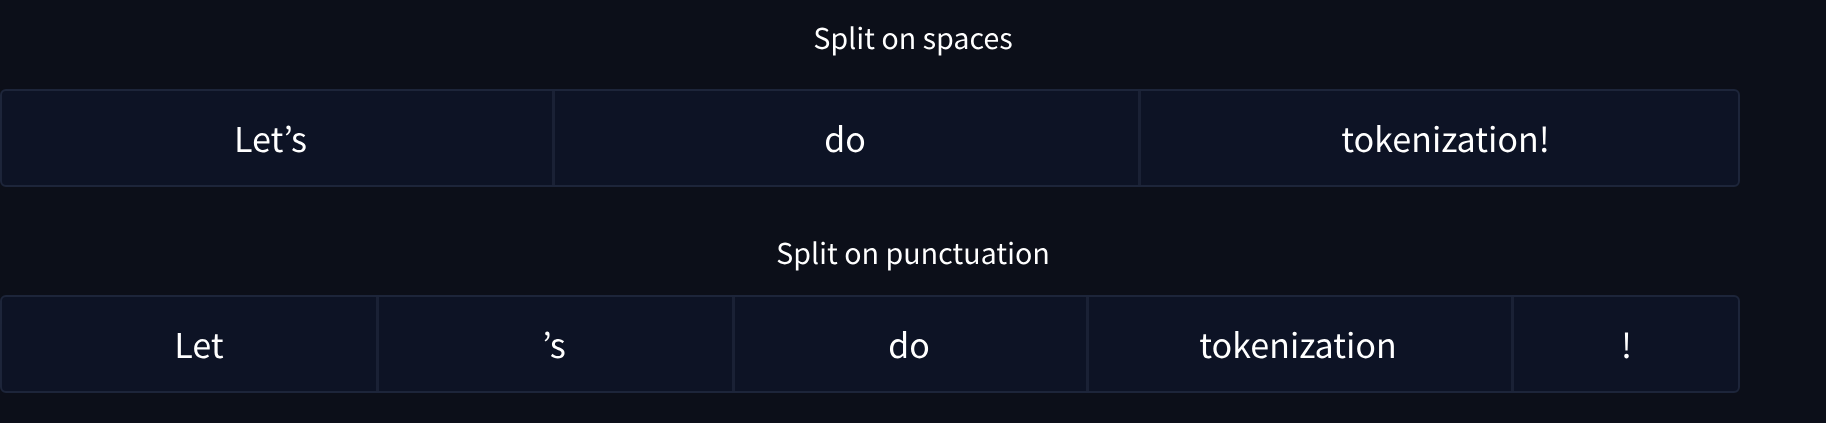

Then, each word is assigned a unique ID from a vocabulary (a list of all known words).

📚 Vocabulary and its Problems:
1. To represent every word in a language, you’d need hundreds of thousands of tokens (English alone has 500,000+ words).
2. Variants like "**dog**" and "**dogs**" get different IDs, even though they’re similar.
3. The model won’t know "**run**" and "**running**" are related unless it learns it from training data.

⚠️ Unknown Token Problem:
1. If a word isn’t in the vocabulary, it’s replaced by a special token like **`[UNK] or <unk>`**.
2. Too many `[UNK]` tokens = **bad** → it means the **model is missing important info**.

#### **2. Character Based**

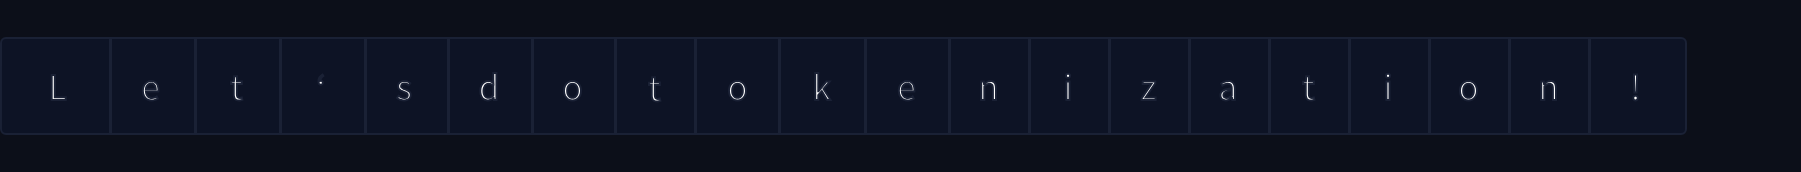

These split text into individual characters, instead of words.
```
Example: "Hello" → ['H', 'e', 'l', 'l', 'o']
```

✅ Benefits:
1.	**Small vocabulary size** → only need to store characters, not whole words.
2.	**Fewer unknown tokens** → every word can be built from characters, so we rarely lose information.

⚠️ Downsides:
*	**Characters have less meaning** on their own compared to full words.
*	**Longer sequences** — a single word might turn into 5–10 tokens, which increases **processing time**.
*	It can be **less efficient** and **harder for the model to capture meaning from such low-level input**.

🈶 Language matters:
*	In languages like Chinese, character tokenization can actually work well, because each character carries more meaning.
*	But in English or other Latin languages, this approach often leads to inefficiency.

#### **3. Subword Tokenization**

Subword tokenizers strike a balance between word-based and character-based tokenization.

💡 Core Idea:
*	Common words → stay as one token.
*	Rare words → broken into smaller, meaningful pieces (subwords).

📍 Example:

```
  "annoyingly" → "annoying" + "ly"
```
**"tokenization" → "token" + "ization"**

These smaller parts still carry **semantic** meaning, which **makes** them useful for the **model** to **understand**.

✅ Benefits:
*	Smaller vocabulary size (compared to word-based).
*	Very few unknown tokens — because rare or new words can still be built from known subwords.
*	More efficient than character-level tokenization.
*	Works great for complex languages like Turkish or Finnish, where words can be made by combining multiple parts.

🛠 Popular Subword Algorithms:
*	Byte Pair Encoding (BPE) – used by GPT models.
*	WordPiece – used by BERT.
*	Unigram – used by models like XLM-RoBERTa.

### Loading and Saving a Tokenizer

Just like models, tokenizers are loaded and saved using:
* `from_pretrained()` → to load a pretrained tokenizer
* `save_pretrained()` → to save it locally

In [25]:
# Loading a BERT Tokenizer:

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

But it’s better to use AutoTokenizer — it’s checkpoint-agnostic (works with any model):

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Now, we can use this tokenizer for our usecase

In [27]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

**Saving a tokenizer is identical to saving a model:**

In [28]:
tokenizer.save_pretrained("directory_on_my_computer")

('directory_on_my_computer/tokenizer_config.json',
 'directory_on_my_computer/special_tokens_map.json',
 'directory_on_my_computer/vocab.txt',
 'directory_on_my_computer/added_tokens.json',
 'directory_on_my_computer/tokenizer.json')

We’ll talk more about token_type_ids, and we’ll explain the attention_mask key a little later. First, let’s see how the **input_ids** are **generated**. To do this, we’ll need to look at the **intermediate methods of the tokenizer**.

### Tokernizer Under the Hood

#### **1. Encoding**

We’ll follow the two key steps:
1.	Tokenization — breaking text into subword tokens
2.	Conversion to Input IDs — mapping those tokens to numbers

the first step is to split the text into words (or parts of words, punctuation symbols, etc.), usually **called** **tokens**. There are multiple rules that can govern that process, which is why we need to instantiate the tokenizer using the name of the model, **to make sure we use the same rules that were used when the model was pretrained**.


The second step is to convert those tokens into numbers, so we can **build** a **tensor** out of them and feed them to the model. To do this, the **tokenizer** has a **vocabulary**, which is the part we **download** when we **instantiate** it with the **from_pretrained**() method. Again, **we need to use the same vocabulary used when the model was pretrained.**


##### **a) Tokenization**

The tokenization process is done by the tokenize() method of the tokenizer:

In [29]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


This tokenizer is a **subword tokenizer**: it splits the words until it obtains tokens that can be represented by its vocabulary. That’s the case here with **transformer**, which is split into two tokens: transform and ##er.

##### **b) From tokens to input IDs**

The conversion to input IDs is handled by the convert_tokens_to_ids() tokenizer method:

In [30]:
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

[7993, 170, 13809, 23763, 2443, 1110, 3014]


These outputs, we can convert to the appropriate framework tensor, can then be used as inputs to a model.

**`raw text ---> tokens ----> input ids ----> tensors ----> Models`**

#### **2. Decoding**

Decoding is going the other way around: from vocabulary indices, we want to get a string. This can be done with the **`decode()`** method as follows:

In [31]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

Using a transformer network is simple


**Note** that the decode method not only converts the indices back to tokens, but **also groups together the tokens** that were part of the same words to produce a readable sentence. This behavior will be extremely useful when we use models that predict new text (either text generated from a prompt, or for sequence-to-sequence problems like translation or summarization).

## **Handling multiple sequences**

we explored the simplest of use cases: doing inference on a single sequence of a small length. However, some questions emerge already:

* How do we handle multiple sequences?
* How do we handle multiple sequences of different lengths?
* Are vocabulary indices the only inputs that allow a model to work well?
* Is there such a thing as too long a sequence?

### **1. Models expect a batch of inputs**

Models expect a batch of inputs.

In [32]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)
# This line will fail.
model(input_ids)

IndexError: too many indices for tensor of dimension 1

**Oh no! Why did this fail?**

	•	input_ids is a 1D tensor, shape: [seq_len]
	•	But the model expects a 2D tensor, shape: [batch_size, seq_len]
	•	So it throws an error like:
  
IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

Because the **model tries to access batch-related dimensions** (like dimension 1 for seq_len), but they don’t exist.

**Using tokenizer with return_tensors=“pt”**

In [33]:
tokenized_inputs = tokenizer(sequence, return_tensors="pt")
print(tokenized_inputs["input_ids"])

tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]])


Behind the scenes, this does everything correctly:

*	Tokenizes the sentence
*	Converts tokens to IDs
*	Adds special tokens like [CLS] and [SEP]
*	Pads/truncates (if needed)
*	Returns a 2D tensor, shape: [1, seq_len] → ✔️ batch of 1

**Instead of using return_tensor, lets add one more dimensions manually**

In [34]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids])
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


Batching is the act of sending multiple sentences through the model, all at once. If you only have one sentence, you can just build a batch with a single sequence:

### **2. Try Batching with Multiple Sentences? and Problems**

Batching allows the model to work when you feed it multiple sentences. Using multiple sequences is just as simple as building a batch with a single sequence.


**Problem:** When you’re trying to batch together two (or more) sentences, they might be of different lengths. If you’ve ever worked with tensors before, you know that they need to be of rectangular shape, so you won’t be able to convert the list of input IDs into a tensor directly.

**Solution:** To work around this problem, we usually pad the inputs.

### **3. Padding**

**What if sequences have different lengths?**

In [35]:
batched_ids = [
    [200, 200, 200],
    [200, 200]
]

Above is invalid tensor shape, so you cannot convert this to tensor, It will fail. Here Padding comes as rescue.

In [37]:
padding_id = 100 # The padding token ID can be found in tokenizer.pad_token_id.

batched_ids = [
    [200, 200, 200],
    [200, 200, padding_id],
]

**🎯 Why do padding tokens cause wrong results?**

In [38]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


If you observe closely, you will get something is wrong. ❌

What is that???

```
model(torch.tensor(sequence2_ids)).logits --> [[ 0.5803, -0.4125]]
model(torch.tensor(batched_ids)).logits --> here output of second --> [ 1.3374, -1.2163]

```

why in batch, logits is different in second sequence.

Because, model considered padding value for processing. But that is wrong. right??

This is because the key feature of Transformer models is attention layers that contextualize each token. These will take into account the padding tokens since they attend to all of the tokens of a sequence.

Now, check carefully the recommendation above. ⬆


### **4. Attention masks**
Attention masks are tensors with the exact same shape as the input IDs tensor, filled with 0s and 1s:

* 1s indicate the corresponding tokens should be attended
* 0s indicate the corresponding tokens should not be attended (i.e., they should be ignored by the attention layers of the model).

In [40]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]
print(model(torch.tensor(sequence2_ids)).logits)
outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


Now we get the same logits for the second sentence in the batch.

Notice how the last value of the second sequence is a padding ID, which is a 0 value in the attention mask.

### **5. Longer sequences**

With Transformer models, there is a limit to the lengths of the sequences we can pass the models. Most models handle sequences of up to 512 or 1024 tokens, and will crash when asked to process longer sequences. There are two solutions to this problem:

* Use a model with a longer supported sequence length.
* Truncate your sequences.

Models have different supported sequence lengths, and some specialize in handling very long sequences. Longformer is one example, and another is LED. If you’re working on a task that requires very long sequences, we recommend you take a look at those models.

Otherwise, we recommend you truncate your sequences by specifying the max_sequence_length parameter:

`sequence = sequence[:max_sequence_length]`

## **Putting all Together**

Transformers API can handle all of this for us with a high-level function that we’ll dive into here. When you call your tokenizer directly on the sentence, you get back inputs that are ready to pass through your model:

In [43]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print(model_inputs)

{'input_ids': [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


1.	Padding Options:
  ```
	•	padding="longest" → pad to the longest sentence in the batch
	•	padding="max_length" → pad to model’s or user-defined max_length
	•	padding=True → auto applies appropriate padding
  ```
2.	Truncation Options:
```
	•	truncation=True → truncate if sequence exceeds model’s max length
	•	max_length=... → specify custom maximum length
```
3.	Return as Tensors:
```
Add return_tensors="pt" (PyTorch) / "tf" / "np" for immediate model
  use
```
6.	Special Tokens Handling:
```
	•	Automatically adds required special tokens like [CLS] and [SEP] based on the model’s architecture.
	•	These are essential for models like BERT, which were pretrained with them.
```

In [44]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)

In [45]:
print(output)

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [-3.6183,  3.9137]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
